In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
import pandas as pd

plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize
plt.rc('figure', titlesize=18)   # fontsize of the figure title

In [2]:
def convert1d2d(arr):
    # convert (m, ) to (m, 1), i.e. 1d to 2d 
    return np.reshape(arr, (-1, 1))

def squaredErrorCost(mat, y, theta):
    m = len(y)
    return 1 / (2*m) * np.linalg.norm( np.subtract( np.dot(design_mat, theta), y ) )**2


def gradientDescent(design_mat, y, theta, alpha=0.01, max_iter=10000):
    # design_mat [m, n]: design matrix [1 x]
    # y [m, 1]: m-dimensional target vector
    # theta [n, 1]: n-dimensional vector, initialized with guess for parameter
    # alpha: learning rate (positive!)
    
    m = len(y)
    for i in range(max_iter):
        theta -= (alpha / m) * np.dot( design_mat.T, (np.subtract( np.dot(design_mat, theta), y )) )  
    return theta

def gradientDescentNotVectorized(mat, y, theta, alpha=0.01, max_iter=10000):
    length = len(y)
    
    for j in range(max_iter):
        update_0 = 0
        update_1 = 0
        for i in range(length):
            error = theta[0] + theta[1] * mat[i, 1] - y[i]
            update_0 += error
            update_1 += error * mat[i, 1] # inner derivate
        theta[0] -= (alpha / length) * update_0
        theta[1] -= (alpha / length) * update_1
    return theta

def gradientDescentTol(mat, y, theta, alpha=0.001, max_iter=100000, tol=0.0001):
    m = len(y)
    J_history = []
    J_history.append(squaredErrorCost(mat, y, theta))
    
    for i in range(max_iter):
        theta -= (alpha / m) * np.dot( design_mat.T, (np.subtract( np.dot(design_mat, theta), y )) )  
        J_history.append(squaredErrorCost(mat, y, theta))
        if abs(J_history[i] - J_history[i+1]) < tol:
            break
    return theta
        
def solveNormalEquations(mat, y):
    # inv(mat.T * mat) * (mat.T * y)
    return np.dot( np.linalg.inv( np.dot(mat.T, mat) ), (np.dot(mat.T, y)) )

# linear regression with a single variable

In [3]:
# loading and transforming data
df1 = pd.read_csv("example_1_data_1.txt")
arr = df1.to_numpy()
x = convert1d2d(arr[:,0])
y = convert1d2d(arr[:,1])

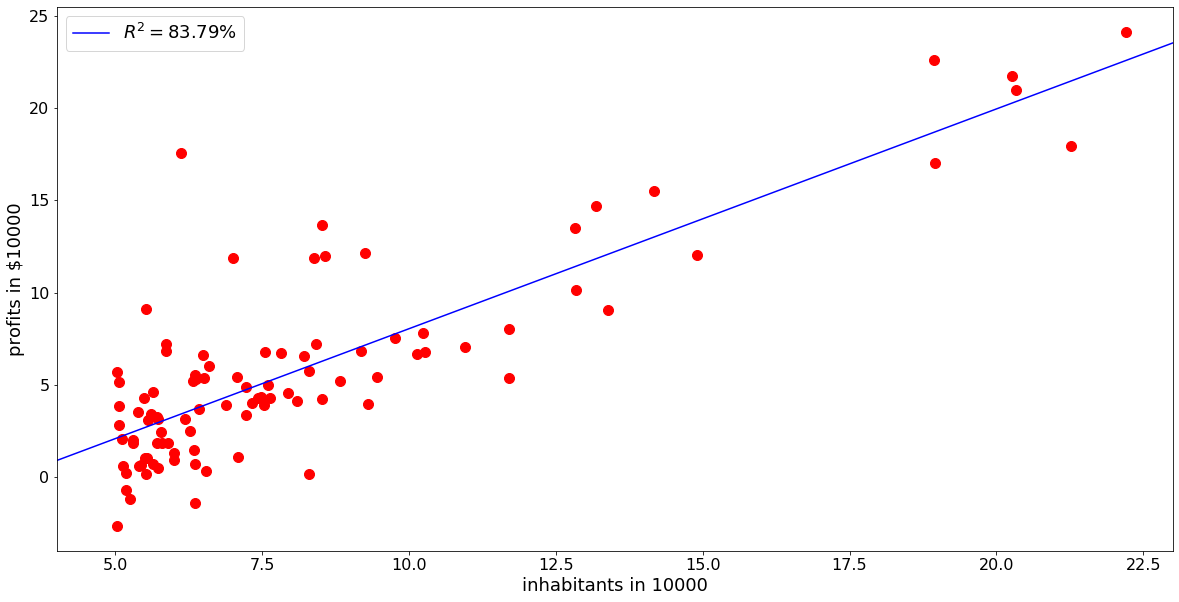

In [4]:
min_x, max_x = 4, 23

theta1, theta0, r2, p_value, std_err = stats.linregress(arr[:,0], arr[:,1])
vals = np.linspace(min_x, max_x, 100)

f = plt.figure(figsize=(20,10))
plt.plot(x, y, color="r", marker="o", markersize="10", ls="none")
plt.plot(vals, theta0 + theta1*vals, color="b", markersize="0", ls="-", label=r"$R^2 = {:.2F}\%$".format(r2*100))
plt.xlabel("inhabitants in 10000")
plt.ylabel("profits in $10000")
plt.xlim(min_x, max_x)
plt.legend(loc="best")
plt.show()

In [5]:
n_points = len(y) # number of data points
theta = np.zeros((2, 1)) # init column vector of parameters 

ones = np.ones((n_points)) # helping array of shape (n_points, )
design_mat = np.c_[ones, x] # concatenate two vectors to matrix

theta2 = gradientDescent(design_mat, y, theta)
theta = np.zeros((2, 1))
theta4 = gradientDescentTol(design_mat, y, theta, tol=0.000001)
theta = np.zeros((2, 1))
theta3 = solveNormalEquations(design_mat, y)
theta = np.zeros((2, 1))

print("linreg from scipy.stats\t h(theta) = {:.10F} + {:.10F} x".format(theta1, theta0))
print("normal equations\t h(theta) = {:.10F} + {:.10F} x".format(theta3[1,0], theta3[0,0]))
print("gradient descent\t h(theta) = {:.10F} + {:.10F} x".format(theta2[1,0], theta2[0,0]))
print("gradient descent tol\t h(theta) = {:.10F} + {:.10F} x".format(theta4[1,0], theta4[0,0]))

linreg from scipy.stats	 h(theta) = 1.1930336442 + -3.8957808783 x
normal equations	 h(theta) = 1.1930336442 + -3.8957808783 x
gradient descent	 h(theta) = 1.1930336384 + -3.8957808203 x
gradient descent tol	 h(theta) = 1.1755032073 + -3.7212806878 x


# linear regression with several variables
The Min-Max Scaler is defined as: (x<sub>i</sub> – min(x)) / (max(x) – min(x)). As it uses the *min* and *max* values, so it’s very sensitive to outliers.<br>
The Standard Scaler is defined as: (x<sub>i</sub> – mean(x)) / stdev(x), which causes problems for data that is not normally distributed.<br>
The Robust Scaler uses statistics that are robust to outliers: (x<sub>i</sub> – Q<sub>1</sub>(x)) / (Q<sub>3</sub>(x) – Q<sub>1</sub>(x))

In [6]:
# loading data and converting to arrays
df2 = pd.read_csv("example_1_data_2.txt")
arr = df2.to_numpy()
X = arr[:,:2]
x1 = convert1d2d(arr[:,0])
x2 = convert1d2d(arr[:,1])
y = convert1d2d(arr[:,2])

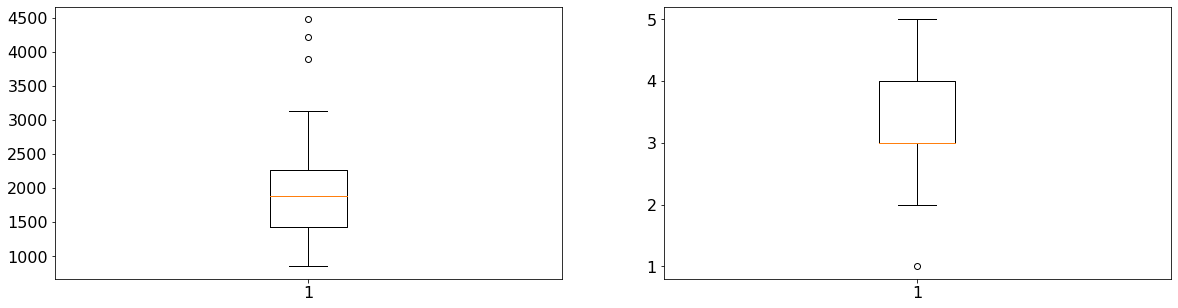

In [7]:
# testing for outliers
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].boxplot(x1)
axs[1].boxplot(x2)
plt.show()

In [8]:
# testing for normal distribution (despite outliers)
w1, p1 = stats.shapiro(x1)
w2, p2 = stats.shapiro(x2)
print("Shapiro-Wilk normality tests:\n  x1: p = {:.5F}\n  x2: p = {:.5F}".format(p1,p2))

Shapiro-Wilk normality tests:
  x1: p = 0.00041
  x2: p = 0.00003


In [9]:
# scaling; different saclers are possible for different features, but obviously not for polynomials 
scaler = RobustScaler()
x1 = scaler.fit_transform(x1)
scaler = MinMaxScaler()
x2 = scaler.fit_transform(x2)

In [10]:
n_points = len(y) # number of data points
theta = np.zeros((3, 1)) # init column vector of parameters 

ones = np.ones((n_points)) # helping array of shape (n_points, )
design_mat = np.c_[ones, x1, x2] # concatenate two vectors to matrix

theta1 = gradientDescent(design_mat, y, theta, 0.001, 100000)
theta = np.zeros((3, 1))
theta2 = solveNormalEquations(design_mat, y)
theta3, res, rank, s = np.linalg.lstsq(design_mat, y, rcond=None) # lstsq solution, residuals, rank, singular values

print("Gradient descent:\t h(theta) = {:.5F} + {:.5F} x1 + {:.5F} x2".format(theta1[0,0], theta1[1,0], theta1[2,0]))
print("Normal equations:\t h(theta) = {:.5F} + {:.5F} x1 + {:.5F} x2".format(theta2[0,0], theta2[1,0], theta2[2,0]))
print("Backslash:\t\t h(theta) = {:.5F} + {:.5F} x1 + {:.5F} x2".format(theta3[0,0], theta3[1,0], theta3[2,0]))

Gradient descent:	 h(theta) = 328962.41189 + 113420.85449 x1 + -7548.16778 x2
Normal equations:	 h(theta) = 343689.64298 + 116519.33415 x1 + -34952.07645 x2
Backslash:		 h(theta) = 343689.64298 + 116519.33415 x1 + -34952.07645 x2


# polynomial regression on "Filip data set"
(without scaling)

In [11]:
# loading data and converting to arrays; src: https://www.itl.nist.gov/div898/strd/lls/data/LINKS/DATA/Filip.dat
df3 = pd.read_csv("example_1_filip.txt", delimiter=",")
arr = df3.to_numpy()
y = convert1d2d(arr[:,0])
x = convert1d2d(arr[:,1])
exact_sol = np.array([-1467.48961422980, -2772.17959193342, -2316.37108160893, -1127.97394098372, -354.478233703349, -75.1242017393757, -10.8753180355343, -1.06221498588947, -0.670191154593408E-01, -0.246781078275479E-02, -0.402962525080404E-04])

In [12]:
dim_par, dim_points = 11, len(y) # number of fitting parameters and data points
theta = np.zeros((dim_par, 1)) # init column vector of parameters 

ones = np.ones((dim_points)) # helping array of shape (n_points, )
design_mat = np.c_[ones, x] # concatenate two vectors to matrix
for i in range(2, 11):
    design_mat = np.c_[design_mat, x**i]

# creating design matrix easily by using vandermonde matrix (cannot use x because x is 2d: [82, 1]);
# reverse column order with np.flip
vander = np.vander(arr[:,1], dim_par)
vander = np.flip(vander, 1)

# show that both methods are equal
print("Vandermonde Matrix is the same as manually created Matrix?", np.allclose(vander, design_mat))

# compute the condition number showing that this problem is ill-conditioned
u, s, v = np.linalg.svd(vander, full_matrices=True)
cond = max(s) / min (s)
print("Condition number: {:.2E}".format(cond))

# solving with different methods
#theta1 = gradientDescent(design_mat, y, theta) # fails
#theta2 = gradientDescentTol(design_mat, y, theta, alpha=0.00001, max_iter=100000, tol=1E-8) # fails
theta3 = solveNormalEquations(design_mat, y)
theta4, res, rank, s = np.linalg.lstsq(vander, y, rcond=None) # lstsq solution, residuals, rank, singular values
theta5, res, rank, s = np.linalg.lstsq(vander, y, rcond=1E-16) # lstsq solution, residuals, rank, singular values
theta6 = np.linalg.pinv(design_mat).dot(y)

d = {'NIST': exact_sol, 'Normal Equations': theta3[:,0], 'pinv': theta6[:,0], 'Backslash (rcond=None)': theta4[:,0], 'Backslash (rcond=1E-16)': theta5[:,0]}
pd.DataFrame(data=d)

Vandermonde Matrix is the same as manually created Matrix? True
Condition number: 1.77E+15


,NIST,Normal Equations,pinv,Backslash (rcond=None),Backslash (rcond=1E-16)
0,-1467.489614,-322.080078,8.443047,8.443047,-1467.496851
1,-2772.179592,-537.041016,1.364999,1.364990,-2772.187164
2,-2316.371082,-378.755859,-5.350746,-5.350760,-2316.374224
3,-1127.973941,-147.368408,-3.341901,-3.341910,-1127.974617
4,-354.478234,-33.793030,-0.406458,-0.406461,-354.478313
5,-75.124202,-4.313786,0.257728,0.257727,-75.124206
6,-10.875318,-0.181120,0.119772,0.119772,-10.875318
7,-1.062215,0.028972,0.023141,0.023141,-1.062215
8,-0.067019,0.005003,0.002404,0.002404,-0.067019
9,-0.002468,0.000310,0.000132,0.000132,-0.002468


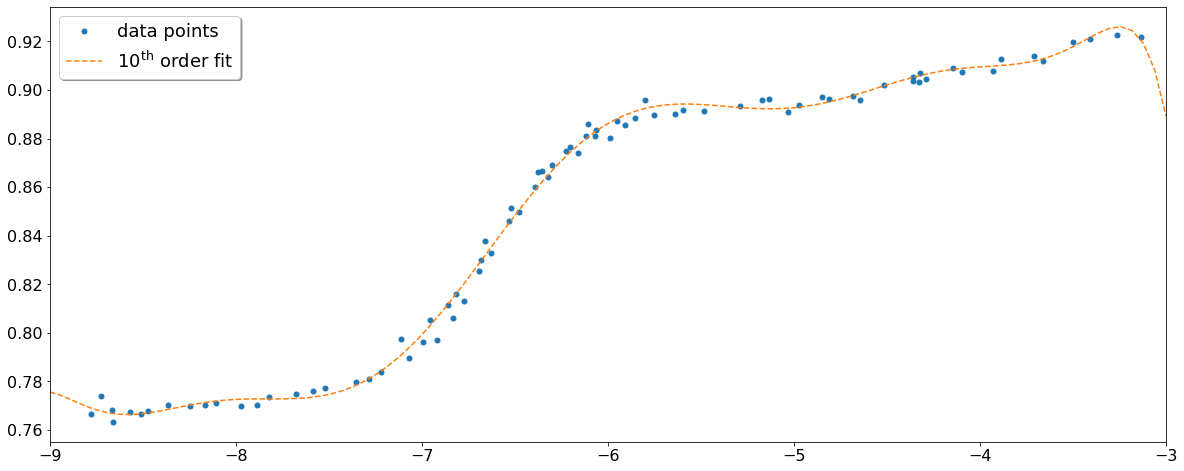

In [13]:
min_x, max_x = -9, -3
fig = plt.figure(figsize=(20, 8))

x_vals = np.linspace(min_x, max_x, 100)
y_vals = np.zeros((100))
for i in range(dim_par):
    y_vals += theta5[i, 0] * x_vals**i # y = theta0 * x^0 + theta1 * x + theta2 * x^2 + ... 

plt.plot(x, y, marker="o", markersize="5", ls="none", label="data points")
plt.plot(x_vals, y_vals, ls="--", label="$10^{\mathrm{th}}$ order fit")
plt.xlim(min_x, max_x)
plt.legend(loc="best", fancybox=True, shadow=True)
plt.show()

# polynomial regression on "Filip data set"
(with feature scaling)

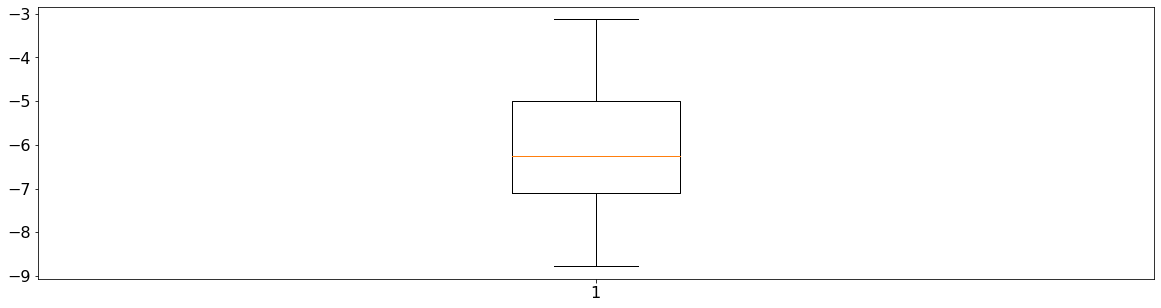

In [14]:
# testing for outliers
fig = plt.figure(figsize=(20, 5))
plt.boxplot(x)
plt.show()

In [15]:
# testing for normal distribution (despite outliers)
w, p = stats.shapiro(x)
print("Shapiro-Wilk normality tests:\n  x: p = {:.5F}".format(p))

Shapiro-Wilk normality tests:
  x: p = 0.06663


In [16]:
# scaling with StandardScaler since p > 0.05
scaler = StandardScaler()
x = scaler.fit_transform(x)

In [17]:
l=5e-9
gnuplot> n=1e4
gnuplot> c=2.6e18
dim_par, dim_points = 11, len(y) # number of fitting parameters and data points
theta = np.zeros((dim_par, 1)) # init column vector of parameters 

# creating design matrix easily by using vandermonde matrix (cannot use x because x is 2d: [82, 1]);
# reverse column order with np.flip
vander = np.vander(x.flatten(), dim_par)
vander = np.flip(vander, 1)

# compute the condition number showing that this problem is ill-conditioned
u, s, v = np.linalg.svd(vander, full_matrices=True)
cond = max(s) / min (s)
print("Condition number: {:.2E}".format(cond))

# solving with different methods
#theta1 = gradientDescent(design_mat, y, theta) # fails
#theta2 = gradientDescentTol(design_mat, y, theta, alpha=0.00001, max_iter=100000, tol=1E-8) # fails
theta3 = solveNormalEquations(vander, y)
theta4, res, rank, s = np.linalg.lstsq(vander, y, rcond=None) # lstsq solution, residuals, rank, singular values
theta5, res, rank, s = np.linalg.lstsq(vander, y, rcond=1E-16) # lstsq solution, residuals, rank, singular values
theta6 = np.linalg.pinv(vander).dot(y)

print("\n(Values are not scaled back.)")
d = {'NIST': exact_sol, 'Normal Equations': theta3[:,0], 'pinv': theta6[:,0], 'Backslash (rcond=None)': theta4[:,0], 'Backslash (rcond=1E-16)': theta5[:,0]}
pd.DataFrame(data=d)

Condition number: 1.15E+04

(Values are not scaled back.)


,NIST,Normal Equations,pinv,Backslash (rcond=None),Backslash (rcond=1E-16)
0,-1467.489614,0.877829,0.877829,0.877829,0.877829
1,-2772.179592,0.097020,0.097020,0.097020,0.097020
2,-2316.371082,-0.148504,-0.148504,-0.148504,-0.148504
3,-1127.973941,-0.051868,-0.051868,-0.051868,-0.051868
4,-354.478234,0.183622,0.183622,0.183622,0.183622
5,-75.124202,0.021825,0.021825,0.021825,0.021825
6,-10.875318,-0.099729,-0.099729,-0.099729,-0.099729
7,-1.062215,-0.004707,-0.004707,-0.004707,-0.004707
8,-0.067019,0.024615,0.024615,0.024615,0.024615
9,-0.002468,0.000391,0.000391,0.000391,0.000391
